### Due to computational limitations from google colab, we illustrate the training and testing of a network on CMC maps using a simplify version of the benchmark codes and also using a fraction of all the data available. We note that the results obtained in this example are far from optimal and are just shown as an illustration.

### Import libraries

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import r2_score
from tqdm import tqdm
# from models import model_o3_err

In [2]:
# import CKA package
# from similarity.CKA import CKA, CudaCKA
# from absl import flags
from similarity.efficient_CKA import *

2023-12-08 12:02:56.018397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 12:02:56.530230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### The code will run on both CPUs or GPUs

In [3]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


### Define the value of the parameters and hyperparameters

In [4]:
# data parameters
fmaps      = ['maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 15   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
# params          = [0,1]
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = True             #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 128
min_lr     = 1e-9
max_lr     = 0.0036  # default: 1e-3
wd         = 0.0258  #value of weight decay, default: 0.0005
dr         = 0.4     #dropout value for fully connected layers, default: 0.2
hidden     = 11       #this determines the number of channels in the CNNs; integer larger than 1, default: 5
epochs     = 50      #number of epochs to train the network

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

In [5]:
# TNG - 43

# data
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
fmaps2 = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'

In [11]:
# SIMBA - 37

# data
fparams = '2D_maps/data/params_LH_SIMBA.txt'
fmaps2 = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

In [6]:
maps  = np.load(fmaps2)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


### These routines define the way the data is input and fed into the network. We then read the data and get the training and validation sets

In [12]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]

# # get training set
# print('\nPreparing training set')
# train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# # get validation set
# print('\nPreparing validation set')
# valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=True,  verbose=True)

### Define the model architecture and use it.

### Full Model (21 layers)

In [13]:
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        # self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)  # TODO

        self.dropout   = nn.Dropout(p=dr)
        # self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        # self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.C01(image))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

        x = self.LeakyReLU(self.B51(self.C51(x)))
        x = self.LeakyReLU(self.B52(self.C52(x)))
        x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))

        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])  # TODO

        return y

# now that architecture is defined above, use it
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 28436376


In [13]:
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 28436376


### 18-layer model

In [8]:
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
#         self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
#                             padding_mode='circular', bias=True)
#         self.B51 = nn.BatchNorm2d(64*hidden)
#         self.B52 = nn.BatchNorm2d(64*hidden)
#         self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx2x2
        self.C61 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(64*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(64*hidden*4, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)  # TODO

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.C01(image))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

#         x = self.LeakyReLU(self.B51(self.C51(x)))
#         x = self.LeakyReLU(self.B52(self.C52(x)))
#         x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))
        x = self.P0(x)

        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])  # TODO

        return y

# now that architecture is defined above, use it
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 8851096


### 15-layer model

In [15]:
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
#         self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
#                             padding_mode='circular', bias=True)
#         self.B41 = nn.BatchNorm2d(32*hidden)
#         self.B42 = nn.BatchNorm2d(32*hidden)
#         self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
#         self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)
#         self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
#                             padding_mode='circular', bias=True)
#         self.B51 = nn.BatchNorm2d(64*hidden)
#         self.B52 = nn.BatchNorm2d(64*hidden)
#         self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx2x2
        self.C61 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(32*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(32*hidden*36, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)  # TODO

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.C01(image))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

#         x = self.LeakyReLU(self.B41(self.C41(x)))
#         x = self.LeakyReLU(self.B42(self.C42(x)))
#         x = self.LeakyReLU(self.B43(self.C43(x)))

#         x = self.LeakyReLU(self.B51(self.C51(x)))
#         x = self.LeakyReLU(self.B52(self.C52(x)))
#         x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))
        x = self.P0(x)

        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])  # TODO

        return y

# now that architecture is defined above, use it
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 10643480


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, 
#                                               cycle_momentum=False, step_size_up=500, step_size_down=500)

In [11]:
print('Computing initial validation loss')
model.eval()
valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        bs   = x.shape[0]                #batch size
        x    = x.to(device=device)       #maps
        y    = y.to(device=device)[:,g]  #parameters
        p    = model(x)                  #NN output
        y_NN = p[:,g]                    #posterior mean
        e_NN = p[:,h]                    #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        valid_loss1 += loss1*bs
        valid_loss2 += loss2*bs
        points += bs
min_valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
min_valid_loss = torch.mean(min_valid_loss).item()
print('Initial valid loss = %.3e'%min_valid_loss)

Computing initial validation loss


NameError: name 'valid_loader' is not defined

In [ ]:
from tqdm import tqdm
# do a loop over all epochs
start = time.time()
for epoch in tqdm(range(200)):

    # do training
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        e_NN = p[:,h]             #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        train_loss1 += loss1*bs
        train_loss2 += loss2*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if points>18000:  break
    train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            e_NN  = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            valid_loss1 += loss1*bs
            valid_loss2 += loss2*bs
            points     += bs
    valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    scheduler.step(valid_loss)

    # verbose
    print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')

    # save model if it is better
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = valid_loss
        print('(C) ', end='')
    print('')

    # save losses to file
    f = open(floss, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
    f.close()

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))


  0%|          | 0/200 [00:00<?, ?it/s]

000 2.863e+01 -6.019e+00 (C) 


  1%|          | 2/200 [10:30<17:15:52, 313.90s/it]

001 -8.666e+00 -7.035e+00 (C) 



  2%|▏         | 3/200 [15:38<17:02:01, 311.28s/it]

002 -9.335e+00 -7.860e+00 (C) 



  2%|▏         | 4/200 [20:46<16:51:58, 309.79s/it]

003 -9.705e+00 -9.063e+00 (C) 



  2%|▎         | 5/200 [25:53<16:43:57, 308.91s/it]

004 -9.935e+00 -9.433e+00 (C) 



  3%|▎         | 6/200 [31:01<16:37:52, 308.62s/it]

005 -1.012e+01 -9.861e+00 (C) 



  4%|▎         | 7/200 [36:09<16:31:45, 308.32s/it]

006 -1.028e+01 -9.038e+00 



  4%|▍         | 8/200 [41:16<16:25:48, 308.06s/it]

007 -1.036e+01 -9.651e+00 



  4%|▍         | 9/200 [46:24<16:20:34, 308.03s/it]

008 -1.047e+01 -1.011e+01 (C) 



  5%|▌         | 10/200 [51:32<16:15:18, 307.99s/it]

009 -1.053e+01 -9.528e+00 



  6%|▌         | 11/200 [56:40<16:10:08, 307.98s/it]

010 -1.056e+01 -9.502e+00 



  6%|▌         | 12/200 [1:01:47<16:03:54, 307.63s/it]

011 -1.063e+01 -6.832e+00 



  6%|▋         | 13/200 [1:06:54<15:58:31, 307.55s/it]

012 -1.069e+01 -9.425e+00 



  7%|▋         | 14/200 [1:12:02<15:53:18, 307.52s/it]

013 -1.072e+01 -9.729e+00 



  8%|▊         | 15/200 [1:17:09<15:48:09, 307.51s/it]

014 -1.075e+01 -9.951e+00 



  8%|▊         | 16/200 [1:22:17<15:43:19, 307.60s/it]

015 -1.075e+01 -8.957e+00 



  8%|▊         | 17/200 [1:27:25<15:38:18, 307.64s/it]

016 -1.081e+01 -5.855e+00 



  9%|▉         | 18/200 [1:32:32<15:32:50, 307.53s/it]

017 -9.890e+00 -9.622e+00 



 10%|▉         | 19/200 [1:37:39<15:27:34, 307.49s/it]

018 -1.083e+01 -6.933e+00 



 10%|█         | 20/200 [1:42:47<15:22:25, 307.47s/it]

019 -1.089e+01 -9.466e+00 



 10%|█         | 21/200 [1:47:54<15:17:19, 307.48s/it]

020 -1.227e+01 -1.195e+01 (C) 



 11%|█         | 22/200 [1:53:02<15:12:25, 307.56s/it]

021 -1.242e+01 -1.149e+01 



 12%|█▏        | 23/200 [1:58:09<15:06:52, 307.41s/it]

022 -1.248e+01 -1.197e+01 (C) 



 12%|█▏        | 24/200 [2:03:17<15:02:03, 307.52s/it]

023 -1.258e+01 -1.191e+01 



 12%|█▎        | 25/200 [2:08:25<14:57:24, 307.68s/it]

024 -1.260e+01 -1.066e+01 



 13%|█▎        | 26/200 [2:13:33<14:52:35, 307.79s/it]

025 -1.265e+01 -1.234e+01 (C) 



 14%|█▎        | 27/200 [2:18:40<14:47:00, 307.63s/it]

026 -1.270e+01 -1.153e+01 



 14%|█▍        | 28/200 [2:23:48<14:42:14, 307.76s/it]

027 -1.276e+01 -1.214e+01 



 14%|█▍        | 29/200 [2:28:56<14:37:10, 307.78s/it]

028 -1.276e+01 -9.790e+00 



 15%|█▌        | 30/200 [2:34:05<14:32:40, 308.00s/it]

029 -1.280e+01 -1.029e+01 



 16%|█▌        | 31/200 [2:39:14<14:28:53, 308.48s/it]

030 -1.283e+01 -1.185e+01 



 16%|█▌        | 32/200 [2:44:22<14:23:01, 308.22s/it]

031 -1.287e+01 -9.948e+00 



 16%|█▋        | 33/200 [2:49:29<14:17:18, 308.02s/it]

032 -1.290e+01 -1.036e+01 



 17%|█▋        | 34/200 [2:54:37<14:12:04, 307.98s/it]

033 -1.293e+01 -1.009e+01 



 18%|█▊        | 35/200 [2:59:45<14:06:50, 307.94s/it]

034 -1.295e+01 -1.041e+01 



 18%|█▊        | 36/200 [3:04:53<14:01:41, 307.93s/it]

035 -1.296e+01 -1.012e+01 



 18%|█▊        | 37/200 [3:10:00<13:56:02, 307.74s/it]

036 -1.299e+01 -1.088e+01 



 19%|█▉        | 38/200 [3:15:08<13:50:28, 307.58s/it]

037 -1.365e+01 -1.189e+01 



 20%|█▉        | 39/200 [3:20:15<13:45:36, 307.68s/it]

038 -1.375e+01 -1.268e+01 (C) 



 20%|██        | 40/200 [3:25:24<13:40:54, 307.84s/it]

039 -1.380e+01 -1.282e+01 (C) 



 20%|██        | 41/200 [3:30:32<13:35:50, 307.86s/it]

040 -1.384e+01 -1.253e+01 



 21%|██        | 42/200 [3:35:39<13:30:38, 307.84s/it]

041 -1.387e+01 -1.254e+01 



 22%|██▏       | 43/200 [3:40:47<13:25:23, 307.79s/it]

042 -1.395e+01 -1.234e+01 



 22%|██▏       | 44/200 [3:45:55<13:20:15, 307.79s/it]

043 -1.395e+01 -1.227e+01 



 22%|██▎       | 45/200 [3:51:03<13:15:04, 307.77s/it]

044 -1.395e+01 -1.234e+01 



 23%|██▎       | 46/200 [3:56:10<13:10:00, 307.80s/it]

045 -1.400e+01 -1.267e+01 



 24%|██▎       | 47/200 [4:01:18<13:04:54, 307.81s/it]

046 -1.402e+01 -1.261e+01 



 24%|██▍       | 48/200 [4:06:27<13:00:42, 308.18s/it]

047 -1.406e+01 -1.234e+01 



 24%|██▍       | 49/200 [4:11:36<12:56:12, 308.43s/it]

048 -1.411e+01 -1.222e+01 



 25%|██▌       | 50/200 [4:16:45<12:51:33, 308.62s/it]

049 -1.412e+01 -1.158e+01 



 26%|██▌       | 51/200 [4:21:55<12:46:55, 308.83s/it]

050 -1.414e+01 -1.243e+01 



 26%|██▌       | 52/200 [4:27:04<12:42:11, 309.00s/it]

051 -1.442e+01 -1.276e+01 



 26%|██▋       | 53/200 [4:32:13<12:37:05, 309.02s/it]

052 -1.449e+01 -1.286e+01 (C) 





### Now test the model

In [20]:
new_state_dict.keys()

dict_keys(['C01.weight', 'C01.bias', 'C02.weight', 'C02.bias', 'C03.weight', 'C03.bias', 'B01.weight', 'B01.bias', 'B01.running_mean', 'B01.running_var', 'B01.num_batches_tracked', 'B02.weight', 'B02.bias', 'B02.running_mean', 'B02.running_var', 'B02.num_batches_tracked', 'B03.weight', 'B03.bias', 'B03.running_mean', 'B03.running_var', 'B03.num_batches_tracked', 'C11.weight', 'C11.bias', 'C12.weight', 'C12.bias', 'C13.weight', 'C13.bias', 'B11.weight', 'B11.bias', 'B11.running_mean', 'B11.running_var', 'B11.num_batches_tracked', 'B12.weight', 'B12.bias', 'B12.running_mean', 'B12.running_var', 'B12.num_batches_tracked', 'B13.weight', 'B13.bias', 'B13.running_mean', 'B13.running_var', 'B13.num_batches_tracked', 'C21.weight', 'C21.bias', 'C22.weight', 'C22.bias', 'C23.weight', 'C23.bias', 'B21.weight', 'B21.bias', 'B21.running_mean', 'B21.running_var', 'B21.num_batches_tracked', 'B22.weight', 'B22.bias', 'B22.running_mean', 'B22.running_var', 'B22.num_batches_tracked', 'B23.weight', 'B23.

In [16]:
# load the weights in case they exists
fmodel = 'best_weights_t_15layers.pt'
# fmodel = 'best_weights_T_TNG.pt'
fmodel = 'layer17_TNG/weights.pt'
fmdoel = 'best_weights_T_TNG_0.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

RuntimeError: Error(s) in loading state_dict for model_o3_err:
	Missing key(s) in state_dict: "C51.weight", "C51.bias", "C52.weight", "C52.bias", "C53.weight", "C53.bias", "B51.weight", "B51.bias", "B51.running_mean", "B51.running_var", "B52.weight", "B52.bias", "B52.running_mean", "B52.running_var", "B53.weight", "B53.bias", "B53.running_mean", "B53.running_var". 
	size mismatch for C61.weight: copying a param with shape torch.Size([704, 352, 4, 4]) from checkpoint, the shape in current model is torch.Size([1408, 704, 4, 4]).
	size mismatch for C61.bias: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([1408]).
	size mismatch for B61.weight: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([1408]).
	size mismatch for B61.bias: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([1408]).
	size mismatch for B61.running_mean: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([1408]).
	size mismatch for B61.running_var: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([1408]).
	size mismatch for FC1.weight: copying a param with shape torch.Size([704, 2816]) from checkpoint, the shape in current model is torch.Size([704, 1408]).

In [10]:
if os.path.exists(fmodel):
    model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

Weights loaded


In [10]:
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550


In [18]:
# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,6), dtype=np.float32)
params_NN   = np.zeros((num_maps,6), dtype=np.float32)
errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

# get test loss
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]    #batch size
        x     = x.to(device)  #send data to device
        y     = y.to(device)  #send data to device
        p     = model(x)      #prediction for mean and variance
        y_NN  = p[:,:6]       #prediction for mean
        e_NN  = p[:,6:]       #prediction for error
        loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
        loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
        test_loss1 += loss1*bs
        test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy()
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Normalized Error Omega_m = %.3f'%Norm_error[0])
print('Normalized Error sigma_8 = %.3f'%Norm_error[1])
print('Normalized Error A_SN1   = %.3f'%Norm_error[2])
print('Normalized Error A_AGN1  = %.3f'%Norm_error[3])
print('Normalized Error A_SN2   = %.3f'%Norm_error[4])
print('Normalized Error A_AGN2  = %.3f\n'%Norm_error[5])

# de-normalize
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum
errors_NN   = errors_NN*(maximum - minimum)

error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Error Omega_m = %.3f'%error[0])
print('Error sigma_8 = %.3f'%error[1])
print('Error A_SN1   = %.3f'%error[2])
print('Error A_AGN1  = %.3f'%error[3])
print('Error A_SN2   = %.3f'%error[4])
print('Error A_AGN2  = %.3f\n'%error[5])

mean_error = np.absolute(np.mean(errors_NN, axis=0))
print('Bayesian error Omega_m = %.3f'%mean_error[0])
print('Bayesian error sigma_8 = %.3f'%mean_error[1])
print('Bayesian error A_SN1   = %.3f'%mean_error[2])
print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
print('Bayesian error A_SN2   = %.3f'%mean_error[4])
print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])

rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
print('Relative error Omega_m = %.3f'%rel_error[0])
print('Relative error sigma_8 = %.3f'%rel_error[1])
print('Relative error A_SN1   = %.3f'%rel_error[2])
print('Relative error A_AGN1  = %.3f'%rel_error[3])
print('Relative error A_SN2   = %.3f'%rel_error[4])
print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

# save results to file
#dataset = np.zeros((num_maps,18), dtype=np.float32)
#dataset[:,:6]   = params_true
#dataset[:,6:12] = params_NN
#dataset[:,12:]  = errors_NN
#np.savetxt(fresults,  dataset)
#np.savetxt(fresults1, Norm_error)


Number of maps in the test set: 750
Test loss = 3.058e+00

Normalized Error Omega_m = 1.822
Normalized Error sigma_8 = 5.829
Normalized Error A_SN1   = 0.827
Normalized Error A_AGN1  = 2.183
Normalized Error A_SN2   = 0.625
Normalized Error A_AGN2  = 0.425

Error Omega_m = 0.729
Error sigma_8 = 2.332
Error A_SN1   = 3.101
Error A_AGN1  = 8.187
Error A_SN2   = 0.937
Error A_AGN2  = 0.637

Bayesian error Omega_m = 0.007
Bayesian error sigma_8 = 0.023
Bayesian error A_SN1   = 0.565
Bayesian error A_AGN1  = 4.924
Bayesian error A_SN2   = 0.062
Bayesian error A_AGN2  = 0.170

Relative error Omega_m = 3.617
Relative error sigma_8 = 3.244
Relative error A_SN1   = 4.871
Relative error A_AGN1  = 19.659
Relative error A_SN2   = 0.842
Relative error A_AGN2  = 0.758



R^2: -41.73478240994945


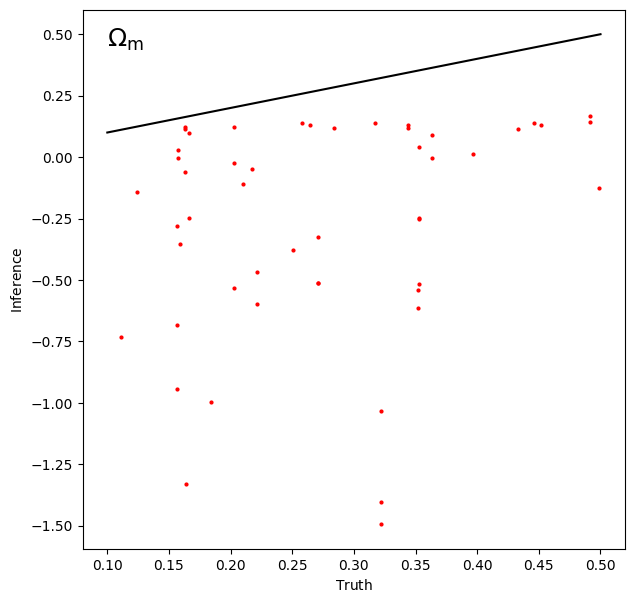

In [19]:
# select the first map of every simulation in the test set
indexes = np.arange(50)*splits

fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.1, 0.45, r'$\Omega_{\rm m}$',fontsize=18)

print("R^2:", r2_score(params_true[indexes,0], params_NN[indexes,0]))

plt.errorbar(params_true[indexes,0], params_NN[indexes,0], #errors_NN[indexes,0],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.1,0.5], [0.1,0.5], color='k')

plt.show()

R^2: -267.1588565979487


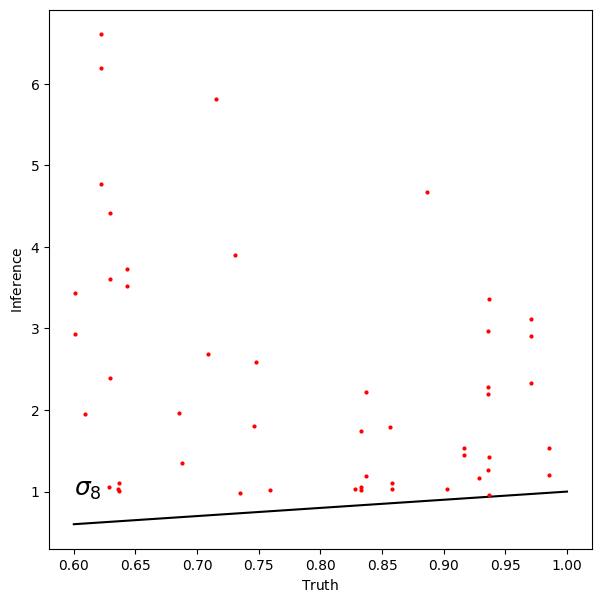

In [20]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.6, 0.95, r'$\sigma_8$',fontsize=18)

print("R^2:", r2_score(params_true[indexes,1], params_NN[indexes,1]))

plt.errorbar(params_true[indexes,1], params_NN[indexes,1],# errors_NN[indexes,1],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.6,1.0], [0.6,1.0], color='k')

plt.show()

## compute CKA similarity

In [9]:
for layer in model.children():
    print(layer)

Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
Conv2d(22, 22, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(22, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
Conv2d(44, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
Conv2d(44, 44, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(44, 88, kern

In [22]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

# Plotting the heatmap with 'magma' colormap and flipping the matrix vertically
def plotHeatmap(heatmap, modelName):
    imshowobj = plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    imshowobj.set_clim(0,1)
    plt.colorbar(label='Similarity')
    plt.title('CKA$_{minibatch}$'+f' - {modelName}')
    plt.xlabel('Layer')
    plt.ylabel('Layer')
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)])
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)])

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"heatmap/Heatmap_{modelName}.png", dpi=300)
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

def plotHeatmap(heatmap, modelName):
    # plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    plt.figure()
    imshowobj = plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    imshowobj.set_clim(0,1)
    plt.colorbar()
    # plt.title('CKA$_{minibatch}$'+f' - {modelName}', fontsize=20)
    plt.title(f'{modelName}', fontsize=24)
    plt.xlabel('Layer', fontsize=20)
    plt.ylabel('Layer', fontsize=20)
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)], fontsize=12)
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)], fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"heatmap/Heatmap_{modelName}.png", dpi=300)
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

In [13]:
model = model.to('cpu')
model.eval()
# n_layers = len(model.layers)
n_layers = 18
cka = MinibatchCKA(n_layers)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for data, target in tqdm(test_loader):
        act = get_activations(data, model, False)
        # print(len(act))
        cka.update_state(act)
        # print(len(data))
        count += len(data)

100%|██████████| 10/10 [03:29<00:00, 20.96s/it]


In [14]:
heatmap = cka.result().numpy()
np.save('heatmap/Layer18_TNG', heatmap)

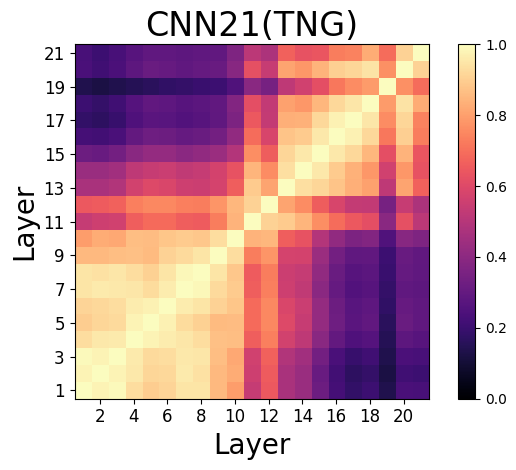

In [23]:
heatmap = np.load('heatmap/Layer21_TNG.npy')
plotHeatmap(heatmap, 'CNN21(TNG)') # accuracy 99.12%

## Across model CKA similarity

In [ ]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

In [ ]:
model = model.to('cpu')
model.eval()

n_layers = 21
across_cka = MinibatchCKA(num_layers=n_layers, num_layers2=n_layers, across_models=True)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for batch_idx, (data1, _) in tqdm(enumerate(test_loader1)):
        data2, _ = next(iter(test_loader2))
        
        act1 = get_activations(data1, model, False)
        act2 = get_activations(data2, model, False)
        across_cka.update_state_across_models(act1, act2)
        
        count += len(data1)

print(count)

In [ ]:
heatmap = cka.result().numpy()
plotHeatmap(heatmap, 'Layer18_TNG') # accuracy 99.12%